<a href="https://colab.research.google.com/github/kasidejcha/net_rate/blob/main/net_rate_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Data

In [77]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import pandas as pd
import numpy as np
from fbprophet import Prophet
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.tsa.api import VAR
from sklearn import preprocessing
# function for mape
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

In [79]:
df = pd.read_csv('/content/drive/My Drive/net_rate/Data/order_fe_status_22jul21.csv')
df['day']= pd.to_datetime(df['day'])
df = df.set_index(['day'])
df = df.sort_index()
df = df[df.index >= pd.to_datetime('2020-07-01')] # cut data
df.tail()

,order_fe_status,count
day,,
2021-07-21,TO_RECEIVE,281517
2021-07-21,TO_PAY,54734
2021-07-21,CANCELLED,150472
2021-07-21,COMPLETED,3956
2021-07-21,TO_SHIP,1161841


In [90]:
dff = pd.DataFrame()
dff['count'] = df['count'].copy()
dff['status'] = df['order_fe_status']
dff = dff.groupby(['status']).sum().reset_index()
print(dff)
# dff.plot.bar(x='status', y='count')

       status      count
0         ALL         39
1   CANCELLED   71965613
2   COMPLETED  438389777
3      TO_PAY      56043
4  TO_RECEIVE    7397479
5     TO_SHIP    2089207


In [81]:
# df[df.index == pd.to_datetime('2021-07-06')].plot.bar(x='order_fe_status', y='count') # one day

In [89]:
compare = pd.DataFrame(df[df['order_fe_status'] == 'COMPLETED']['count']).rename(columns={'count':'COMPLETED'})
compare['CANCELLED'] = df[df['order_fe_status'] == 'CANCELLED']['count']
compare['TO_RECEIVE'] = df[df['order_fe_status'] == 'TO_RECEIVE']['count']
compare['TO_SHIP'] = df[df['order_fe_status'] == 'TO_SHIP']['count']
compare['TO_PAY'] = df[df['order_fe_status'] == 'TO_PAY']['count']
compare['ALL'] = df[df['order_fe_status'] == 'ALL']['count']
compare.fillna(0, inplace=True)
compare['receive_ratio'] = compare['TO_RECEIVE']/(compare['CANCELLED']+compare['TO_RECEIVE']+compare['TO_SHIP']+compare['TO_PAY']+compare['ALL']+compare['COMPLETED'])
compare['to_ship_ratio'] = compare['TO_SHIP']/(compare['CANCELLED']+compare['TO_RECEIVE']+compare['TO_SHIP']+compare['TO_PAY']+compare['ALL']+compare['COMPLETED'])
compare['completed_ratio'] = compare['COMPLETED']/(compare['CANCELLED']+compare['TO_RECEIVE']+compare['TO_SHIP']+compare['TO_PAY']+compare['ALL']+compare['COMPLETED'])
compare['cancelled ratio'] = compare['CANCELLED']/(compare['CANCELLED']+compare['TO_RECEIVE']+compare['TO_SHIP']+compare['TO_PAY']+compare['ALL']+compare['COMPLETED'])
compare['net_rate'] = (compare['TO_RECEIVE']+compare['COMPLETED'])/(compare['TO_RECEIVE']+compare['COMPLETED']+compare['CANCELLED'])

old_nr = pd.read_csv('/content/drive/My Drive/net_rate/Data/discount_vrate_all.csv').drop('type',axis=1)
old_nr.set_index('grass_date',inplace=True)
old_nr.rename(columns={'value':'old_net_rate'},inplace=True)
compare = compare.join(old_nr, how='left')

# compare[compare.index>='2021-07-01'] # check -7 days

In [91]:
# compare[compare.index>='2021-07-13'] # check before -7 days

In [84]:
# compare.to_csv('data.csv')

In [92]:
data = compare[compare.index <= '2021-07-13'] # -7 days from data
net_rate = pd.DataFrame(data.copy()['net_rate'])

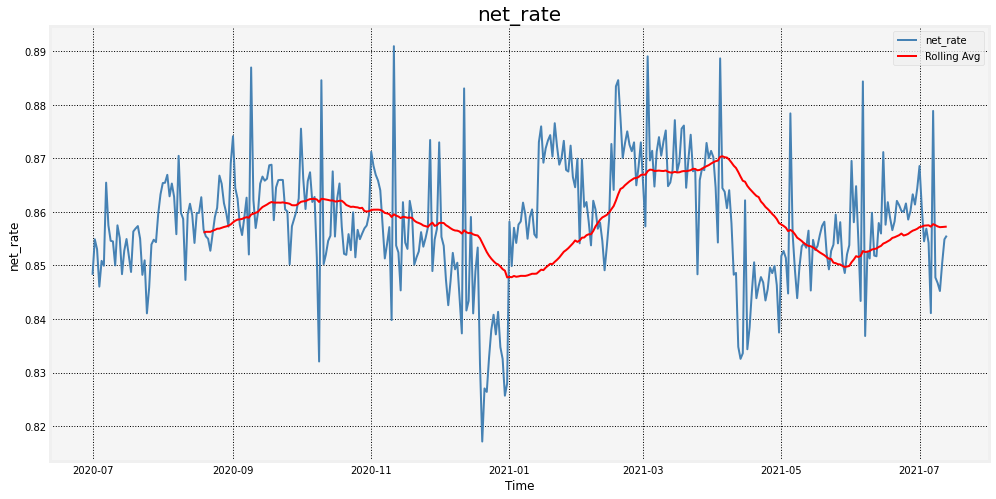

In [93]:
df_roll = data['net_rate'].rolling(window=50).mean()

# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(data['net_rate'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(df_roll, label = 'Rolling Avg', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

In [94]:
# train test split
val_len = 30
net_rate = net_rate.reset_index()
net_rate.rename(columns={'day':'date'},inplace=True)
train = net_rate[:-val_len]
val = net_rate[-val_len:].reset_index(drop=True)
val.tail()

,date,net_rate
25,2021-07-09,0.846714
26,2021-07-10,0.845234
27,2021-07-11,0.850459
28,2021-07-12,0.854894
29,2021-07-13,0.855573


In [95]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(train['net_rate'])

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

adfuller_test(train['net_rate'])

ADF Test Statistic : -3.907367782226964
p-value : 0.001981288432308503
#Lags Used : 3
Number of Observations Used : 344
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


## Prophet single variable Forecasting

In [ ]:
# formatting for Prophet
train_prophet = train.copy().rename(columns={'date':'ds', 'net_rate': 'y'})
train_prophet['ds'] = to_datetime(train_prophet['ds'])

In [ ]:
model = Prophet()
model.fit(train_prophet)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
future = model.make_future_dataframe(periods=len(val))
future.tail()

,ds
373,2021-07-09
374,2021-07-10
375,2021-07-11
376,2021-07-12
377,2021-07-13


In [ ]:
forecast1 = model.predict(future)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
373,2021-07-09,0.871694,0.863770,0.879952
374,2021-07-10,0.870150,0.861979,0.878186
375,2021-07-11,0.873114,0.864282,0.881929
376,2021-07-12,0.873186,0.865547,0.881168
377,2021-07-13,0.872829,0.864737,0.881186


In [ ]:
from fbprophet.plot import plot_plotly, plot_components_plotly
plot_plotly(model, forecast1)

In [ ]:
result = val.copy()
result.rename(columns={'net_rate':'actual','date':'ds'},inplace=True)
result['forecast'] = forecast1['yhat'][-len(val):].reset_index(drop=True)
result.set_index('ds',inplace=True)
result.index = to_datetime(result.index)

In [ ]:
# Metrics
forecast = result.copy()
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.000107
rmse,0.010325
mae,0.009955
mape,1.140753
mdae,0.010620
mdape,1.231359


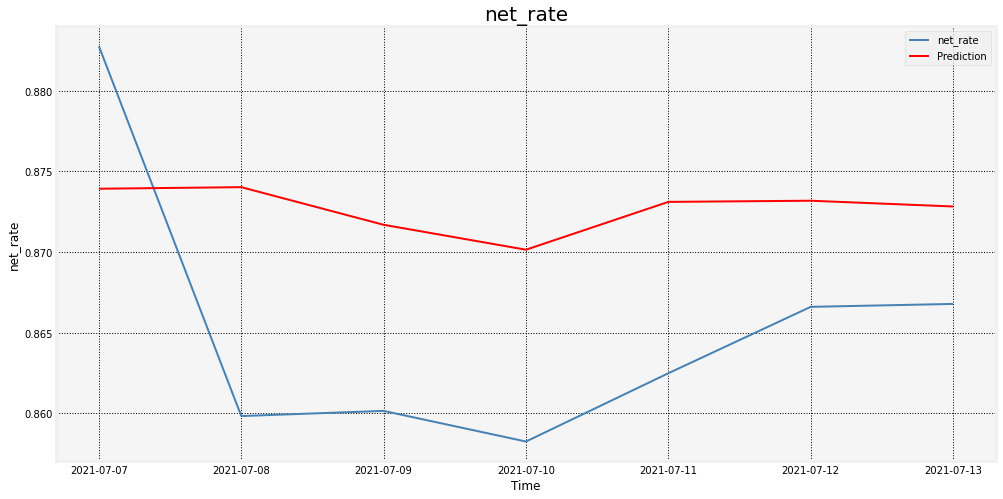

In [ ]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

## Prophet Multivariable Forecasting

In [209]:
# feature engineering
# log return: assume that prices are distributed log normally
eng = train.copy()
eng = eng.append(val).reset_index(drop=True)
print(eng.tail())
print('')
print('total len:', len(eng))
print('train len:', len(train))
print('val len:', len(val))
# https://quantivity.wordpress.com/2011/02/21/why-log-returns/

          date  net_rate
373 2021-07-09  0.846714
374 2021-07-10  0.845234
375 2021-07-11  0.850459
376 2021-07-12  0.854894
377 2021-07-13  0.855573

total len: 378
train len: 348
val len: 30


In [210]:
dday = []
for i in range(len(eng)):
    st = str(eng.date[i])
    if st[5:7] == st[8:10]:
        day = 1
        dday.append(day)
        continue
    if st[8:10] == '15':
        day = 1
        dday.append(day)
        continue
    else:
        day = 0
        dday.append(day)

eng['dday'] = dday
eng.tail()

,date,net_rate,dday
373,2021-07-09,0.846714,0
374,2021-07-10,0.845234,0
375,2021-07-11,0.850459,0
376,2021-07-12,0.854894,0
377,2021-07-13,0.855573,0


In [211]:
season=[]
summer = [3,4,5,6]
rain = [7,8,9,10]
winter = [11,12,1,2]

for i in range(len(eng)):
  st = str(eng.date[i])
  if int(st[5:7]) in summer:
    num_season = 0
    season.append(num_season)
    continue
  if int(st[5:7]) in rain:
    num_season = 1
    season.append(num_season)
    continue
  if int(st[5:7]) in winter:
    num_season = 2
    season.append(num_season)
    continue

eng['season'] = season
eng.tail()

,date,net_rate,dday,season
373,2021-07-09,0.846714,0,1
374,2021-07-10,0.845234,0,1
375,2021-07-11,0.850459,0,1
376,2021-07-12,0.854894,0,1
377,2021-07-13,0.855573,0,1


In [212]:
multi_eng = eng.copy()
multi_eng.rename(columns={'date':'ds','net_rate':'y'},inplace=True)
multi_eng.tail()

,ds,y,dday,season
373,2021-07-09,0.846714,0,1
374,2021-07-10,0.845234,0,1
375,2021-07-11,0.850459,0,1
376,2021-07-12,0.854894,0,1
377,2021-07-13,0.855573,0,1


In [213]:
# train & test split
multi_train = multi_eng[:-len(val)]
multi_val = multi_eng[-len(val):]
multi_train.tail() # input train dataset

,ds,y,dday,season
343,2021-06-09,0.851309,0,0
344,2021-06-10,0.859842,0,0
345,2021-06-11,0.851860,0,0
346,2021-06-12,0.851715,0,0
347,2021-06-13,0.857927,0,0


In [214]:
multi_model = Prophet(interval_width=0.95,weekly_seasonality=True)

In [215]:
multi_model.add_regressor('dday', standardize=False)
multi_model.add_regressor('season', standardize=False)

In [216]:
multi_model.fit(multi_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [217]:
multi_future = multi_model.make_future_dataframe(periods=len(multi_val))
multi_future['dday'] = multi_eng['dday']
multi_future['season'] = multi_eng['season']
multi_future.tail()

,ds,dday,season
373,2021-07-09,0,1
374,2021-07-10,0,1
375,2021-07-11,0,1
376,2021-07-12,0,1
377,2021-07-13,0,1


In [218]:
multi_forecast = multi_model.predict(multi_future)
multi_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
373,2021-07-09,0.849554,0.833319,0.867857
374,2021-07-10,0.847434,0.830114,0.865053
375,2021-07-11,0.851062,0.832588,0.869682
376,2021-07-12,0.850906,0.832777,0.869940
377,2021-07-13,0.849708,0.832196,0.869822


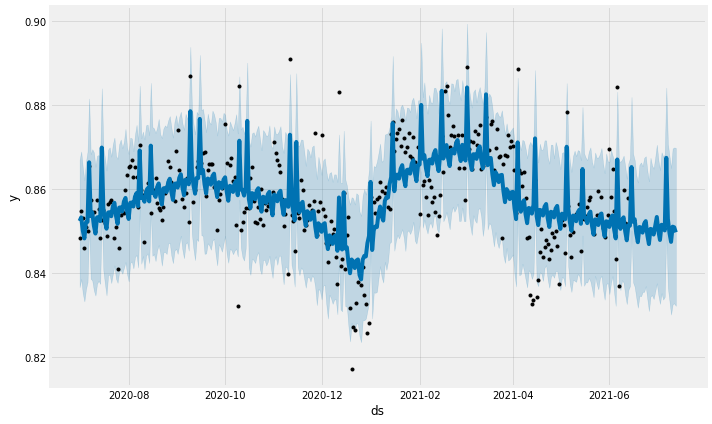

In [219]:
multi_fig = multi_model.plot(multi_forecast)

In [220]:
forecast = multi_forecast[['ds','yhat']][-len(val):].reset_index(drop=True)
forecast.rename(columns={'yhat':'forecast'}, inplace=True)
forecast['actual'] = val['net_rate']
forecast.set_index('ds',inplace=True)
forecast.tail()

,forecast,actual
ds,,
2021-07-09,0.849554,0.846714
2021-07-10,0.847434,0.845234
2021-07-11,0.851062,0.850459
2021-07-12,0.850906,0.854894
2021-07-13,0.849708,0.855573


In [221]:
# root mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,0.000080
rmse,0.008928
mae,0.008133
mape,0.955062
mdae,0.008714
mdape,1.012095


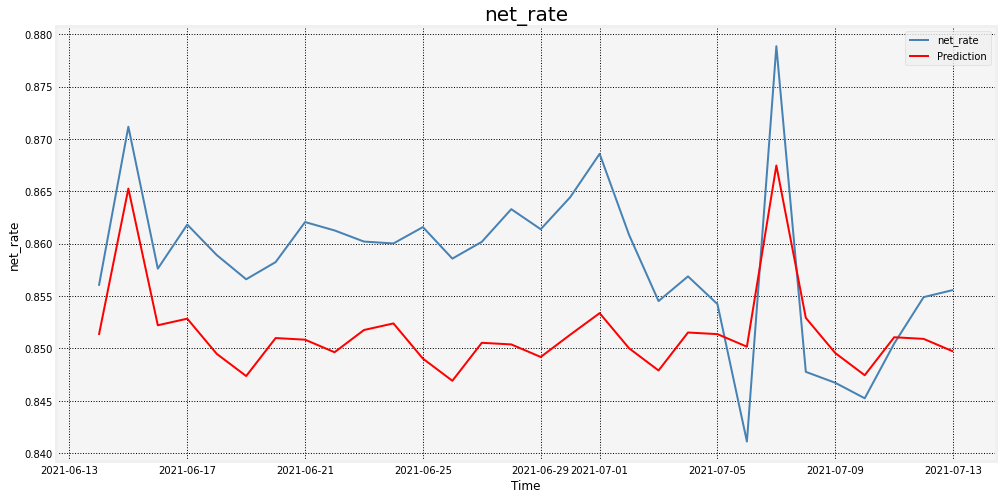

In [222]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

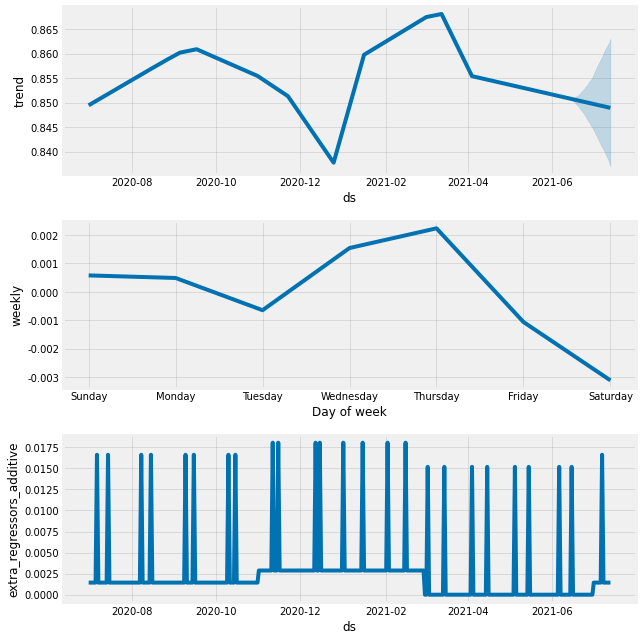

In [223]:
fig2 = multi_model.plot_components(multi_forecast)

## Prophet Multivaraible Cross Validation

In [145]:
# cross validation functions

def rolling_forecast_origin(train, min_train_size, horizon):
  '''
  Rolling forecast origin generator
  '''
  for i in range(len(train)-min_train_size - horizon +1):
    split_train = train[:min_train_size+i]
    split_val = train[min_train_size+i:min_train_size+i+horizon]
    yield split_train, split_val

def sliding_window(train, window_size, horizon):
  '''
  sliding window generator
  '''
  for i in range(len(train)-window_size-horizon+1):
    split_train = train[i:window_size+i]
    split_val = train[i+window_size:window_size+i+horizon]
    yield split_train, split_val

In [201]:
def cross_validation_score(train, cv):
  '''
  Calculate cross validation error
  '''
  cv_scores=[]
  for cv_train, cv_test in cv:
    model = Prophet(interval_width=0.95, weekly_seasonality=True)
    model.add_regressor('dday', standardize=False)
    model.add_regressor('season', standardize=False)
    cv_train = cv_train.reset_index(drop=True)
    cv_test = cv_test.reset_index(drop=True)
    model.fit(cv_train)
    cv_future = model.make_future_dataframe(periods=len(cv_test))
    cv_data = cv_train.append(cv_test).reset_index(drop=True)
    cv_future['dday'] = cv_data['dday']
    cv_future['season'] = cv_data['season']
    cv_forecast = multi_model.predict(cv_future)
    forecast_cv = cv_forecast[['ds','yhat']][-len(cv_test):].reset_index(drop=True)
    forecast_cv.rename(columns={'yhat':'forecast'}, inplace=True)
    forecast_cv['actual'] = cv_test['y']
    forecast_cv.set_index('ds',inplace=True)
    score = MAPE(forecast_cv['forecast'], forecast_cv['actual'])
    cv_scores.append(score)
  return np.array(cv_scores)

In [198]:
cv_test_len = len(multi_val)
cv_rolling = rolling_forecast_origin(train = multi_eng, 
                                     min_train_size=300,
                                     horizon=cv_test_len)

cv_sliding = sliding_window(train = multi_eng, 
                                     window_size=300,
                                     horizon=cv_test_len)

cv_score_rolling = cross_validation_score(train = multi_eng, cv = cv_rolling)
cv_score_sliding = cross_validation_score(train = multi_eng, cv = cv_sliding)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Text(0, 0.5, 'mape')

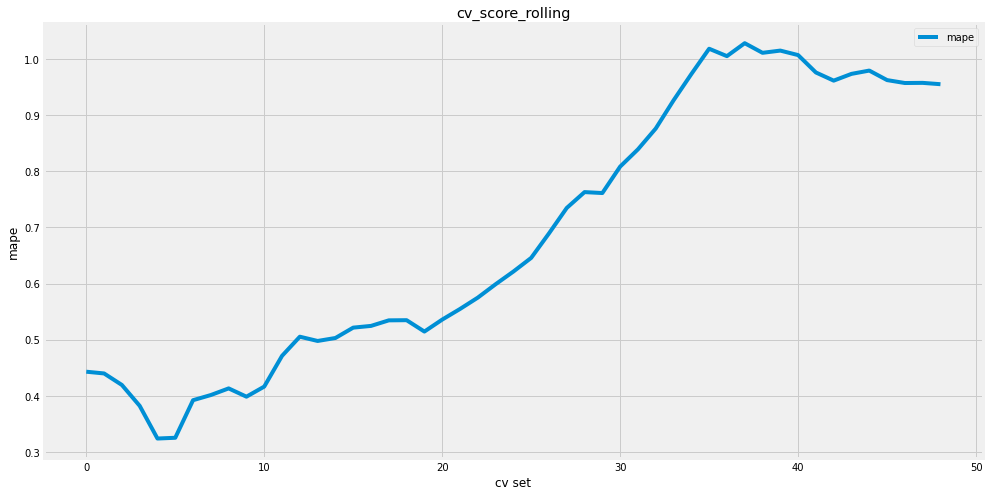

In [206]:
cv_score_rolling = pd.DataFrame(cv_score_rolling, columns={'mape'})
cv_score_rolling.plot()
plt.title('cv_score_rolling')
plt.xlabel('cv set')
plt.ylabel('mape')

Text(0, 0.5, 'mape')

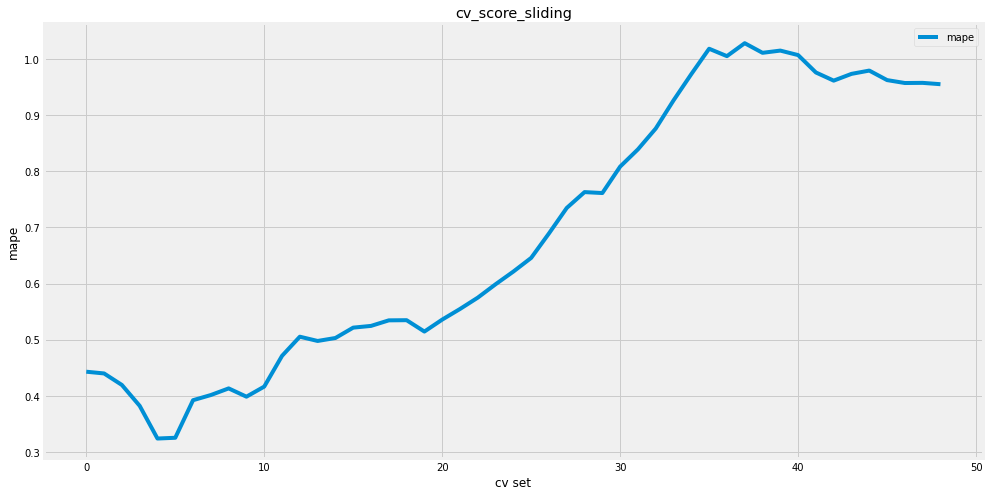

In [208]:
cv_score_sliding = pd.DataFrame(cv_score_sliding, columns={'mape'})
cv_score_sliding.plot()
plt.title('cv_score_sliding')
plt.xlabel('cv set')
plt.ylabel('mape')

In [ ]:
# cv_sliding = sliding_window(train = multi_eng, 
#                                      window_size=300,
#                                      horizon=cv_test_len)
# i=0
# for cv_train, cv_val in cv_sliding:
#   print(f'CV[{i+1}]')
#   print(f'Train:\t{cv_train}')
#   print(pd.DataFrame(cv_train).isnull().values.any())
#   print(f'Val:\t{cv_val}')
#   print(pd.DataFrame(cv_val).isnull().values.any())
#   print('----')
#   i+=1

In [ ]:
# from fbprophet.diagnostics import cross_validation, performance_metrics
# init = str(len(multi_train))+' days' 
# # init = len(multi_train) # decrease 1 day
# hori = str(len(multi_val))+' days'
# cv = cross_validation(model = multi_model, initial = init, horizon = hori)

In [30]:
# performance_metrics(cv)

In [31]:
# from fbprophet.plot import plot_cross_validation_metric

# fig3 = plot_cross_validation_metric(cv,metric='mape')

## VAR Multivariable Forecasting

                 gmv_usd
grass_date              
2020-07-01  3.217051e+06
2020-07-02  3.047198e+06
2020-07-03  2.922012e+06
2020-07-04  2.500780e+06
2020-07-05  2.368386e+06
...                  ...
2021-07-15  8.149545e+06
2021-07-16  5.696099e+06
2021-07-17  4.177975e+06
2021-07-18  3.740570e+06
2021-07-19  4.126154e+06

[384 rows x 1 columns]



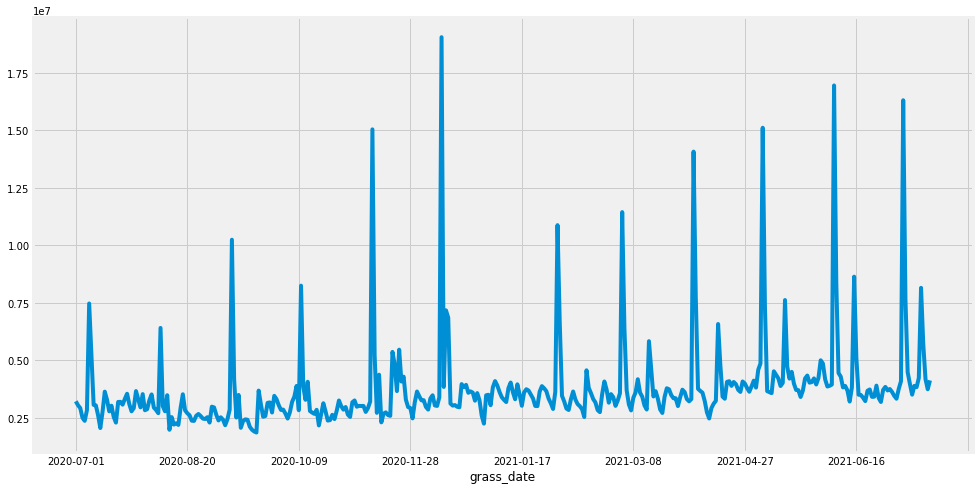

In [ ]:
gmv_com_can = pd.read_csv('/content/drive/My Drive/net_rate/Data/gmv_order_mart_com&can_21jul21.csv')
gmv_com_can = gmv_com_can[gmv_com_can.grass_date != '9999-01-01']
gmv_com_can.reset_index(inplace=True, drop=True)
gmv_com_can = gmv_com_can.set_index(['grass_date'])
gmv_com_can = gmv_com_can.sort_index()
gmv_com_can = gmv_com_can[gmv_com_can.index>= '2020-07-01']
gmv_com = gmv_com_can[gmv_com_can.order_fe_status == 'COMPLETED'].drop(['order_fe_status'],axis=1).drop(['2021-07-20'])
gmv_can = gmv_com_can[gmv_com_can.order_fe_status == 'CANCELLED'].drop(['order_fe_status'],axis=1).drop(['2021-07-20'])
print(gmv_can)
print('')
gmv_can.gmv_usd.plot()

In [ ]:
# normalization
norm = preprocessing.MinMaxScaler()
gmv_com_norm = norm.fit_transform(gmv_com.to_numpy())
gmv_can_norm = norm.fit_transform(gmv_can.to_numpy())

eng_var = eng.copy()
eng_var = eng_var.set_index('date').drop(['season'],axis=1)
eng_var['gmv_com'] = gmv_com_norm
eng_var['gmv_can'] = gmv_can_norm
eng_var.gmv_com = eng_var.gmv_com.diff()
eng_var.gmv_can = eng_var.gmv_can.diff()
eng_var.dropna(inplace=True)
eng_var.index = to_datetime(eng_var.index)
eng_var.drop('dday',axis=1,inplace=True)
print('null: ', eng_var.isnull().values.any())
print(eng_var)
# eng_var.gmv_can.plot()

# VAR assumes stationary -> need to make data stationary
for i in range(len(eng_var.columns)):
  result = adfuller(eng_var[eng_var.columns[i]])
  # print(result)
  if result[1]>0.05:
    print('{} - series is not stationary'. format(eng_var.columns[i]))
  else:
    print('{} - series is stationary'. format(eng_var.columns[i]))

ValueError: ignored

In [ ]:
# train val split
var_train = eng_var[:-len(val)]
var_val = eng_var[-len(val):].drop(['gmv_com','gmv_can'],axis=1)
var_train.tail()

In [ ]:
var_model = VAR(var_train, freq='1D')

In [ ]:
var_model.select_order(50).summary()

In [ ]:
var_model = VAR(var_train, freq='1D')
lag = 31
var_model = var_model.fit(lag) # lag with lowest AIC and BIC is 2

In [ ]:
var_model.summary()

In [ ]:
lag = var_model.k_ar 
val_results = var_model.forecast(var_train.values[-lag:], steps=len(val))
val_results

In [ ]:
forecast=var_val.copy()
forecast['forecast'] = val_results[:,0]
# forecast.drop('dday',axis=1,inplace=True)
forecast.reset_index(inplace=True)
forecast.rename(columns={'net_rate':'actual','date':'ds'}, inplace=True)
forecast.set_index('ds',inplace=True)
forecast.tail()

In [ ]:
mse = mean_squared_error(forecast['forecast'], forecast['actual'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(forecast['forecast'], forecast['actual'])

# mean absolute error
mae = mean_absolute_error(forecast['forecast'], forecast['actual'])

# mean squared error
mse = mean_squared_error(forecast['forecast'], forecast['actual'])

# median absolute error
MDAE = np.median(abs(forecast['forecast']-forecast['actual']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(forecast['forecast'], forecast['actual'])/ forecast['actual']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

In [ ]:
# Plot Data
plt.style.use('fivethirtyeight')
%matplotlib inline

plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize'] = (15.0, 8) # set the size of figure
plt.subplot(facecolor = "whitesmoke") # set the background color
plt.plot(forecast['actual'],label = 'net_rate',color="steelblue", linestyle="-", linewidth=2.0) # plot with set the line width,shape and color
plt.plot(forecast['forecast'], label = 'Prediction', color="Red", linewidth=2.0)
plt.legend()

plt.xlabel("Time")
plt.ylabel("net_rate")
plt.title("net_rate", fontsize = 20)
plt.grid(color="k", linestyle=":") # set grid and line shape

# plt.savefig('Daily cases.png')
plt.show()

# Cost Calculation

In [ ]:
cost = pd.read_csv('/content/drive/My Drive/net_rate/Data/cost_fixed.csv')
coin_rate = pd.read_csv('/content/drive/My Drive/net_rate/Data/coin_rate.csv')

cost = cost.set_index(['date'])
cost = cost.sort_index()
cost = cost[cost.index>= '2020-07-01']
# cost.reset_index(inplace=True)
print('cost null: ', cost.isnull().values.any())
sum_cost = cost.drop('order_fe_status',axis=1).groupby(cost.index).sum()
cost_com = cost[cost['order_fe_status']=='COMPLETED'].drop('order_fe_status',axis=1)+cost[cost['order_fe_status']=='TO_RECEIVE'].drop('order_fe_status',axis=1)

coin_rate = coin_rate[coin_rate.grass_date>='2020-07-01']
coin_rate.drop_duplicates(subset=['grass_date'], inplace=True)
coin_rate.set_index('grass_date',inplace=True)
coin_rate = coin_rate.sort_index()
print('coin_rate null: ', coin_rate.isnull().values.any())

cal = forecast
cal = cal.join(sum_cost, how='left')
coin_rate.reset_index(inplace=True)
cal.reset_index(inplace=True)
coin_r = []
for i in range(len(cal)):
  st = str(cal.ds[i])
  if int(st[5:7]) == 6:
    coin_r.append(0.975924)
  if int(st[5:7]) == 7:
    coin_r.append(0.975924)
cal['coin_rate'] = coin_r
cal.set_index('ds',inplace=True)

old_nr = pd.read_csv('/content/drive/My Drive/net_rate/Data/discount_vrate_all.csv').drop('type',axis=1)
old_nr.set_index('grass_date',inplace=True)
old_nr.rename(columns={'value':'old_nr'},inplace=True)
cal = cal.join(old_nr, how='left')
cal

cost null:  False
coin_rate null:  False


,forecast,actual,item_rebate_by_shopee_amt_usd,estimate_shipping_rebate_by_shopee_amt_usd,actual_shipping_rebate_by_shopee_amt_usd,coin_earn_cash_amt_usd,pv_rebate_by_shopee_amt_usd,sv_rebate_by_shopee_amt_usd,pv_coin_earn_by_shopee_amt_usd,sv_coin_earn_by_shopee_amt_usd,coin_rate,old_nr
ds,,,,,,,,,,,,
2021-06-14,0.865356,0.867669,5.025176e+04,3.380098e+05,2.983548e+05,1.299167e+05,1.467653e+05,7563.335824,1.079134e+05,1193.547228,0.975924,0.898944
2021-06-15,0.875428,0.876881,6.089762e+05,1.430607e+06,1.296414e+06,4.834006e+05,2.541019e+06,13929.507805,3.724634e+05,14254.651168,0.975924,0.899736
2021-06-16,0.866202,0.868980,1.089952e+05,3.110556e+05,2.739686e+05,1.626066e+05,1.866769e+05,5426.203931,1.357273e+05,1230.737560,0.975924,0.899733
2021-06-17,0.866700,0.873369,5.402475e+04,3.766459e+05,3.350383e+05,1.123280e+05,1.675038e+05,4782.414311,9.483317e+04,1321.056939,0.975924,0.899452
2021-06-18,0.864250,0.870672,6.536947e+04,3.286305e+05,2.904714e+05,1.163878e+05,1.938069e+05,6669.807682,9.619356e+04,1242.163506,0.975924,0.899366
2021-06-19,0.862003,0.868426,5.072048e+04,3.800874e+05,3.355801e+05,1.038714e+05,2.074205e+05,8929.264404,8.516445e+04,1021.934007,0.975924,0.899124
2021-06-20,0.865346,0.870019,3.640662e+04,3.452461e+05,3.044155e+05,1.192134e+05,1.516701e+05,6364.475692,1.027544e+05,916.764099,0.975924,0.899450
2021-06-21,0.865475,0.872712,6.983400e+04,3.447765e+05,3.055607e+05,1.926784e+05,1.716071e+05,5720.141980,1.719015e+05,440.523009,0.975924,0.883527
2021-06-22,0.864571,0.872944,6.947865e+04,3.178264e+05,2.813494e+05,4.461310e+05,1.566231e+05,5656.291108,4.226694e+05,438.538671,0.975924,0.882560


## cost with new net rate

Text(0.5, 1.0, 'Item Rebate')

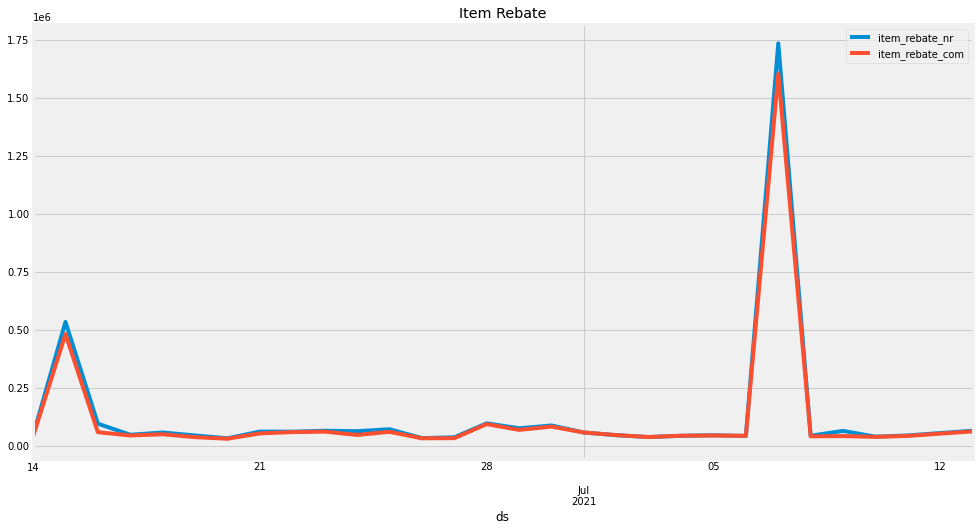

In [ ]:
# item_rebate
item_rebate_nr = cal['forecast']*cal['item_rebate_by_shopee_amt_usd']
item_rebate = pd.DataFrame(item_rebate_nr,columns={'item_rebate_nr'})
item_rebate_com = pd.DataFrame(cost_com['item_rebate_by_shopee_amt_usd'])
item_rebate = item_rebate.join(item_rebate_com['item_rebate_by_shopee_amt_usd'],how='left').rename(columns={'item_rebate_by_shopee_amt_usd':'item_rebate_com'})
item_rebate.plot()
plt.title('Item Rebate')

Text(0.5, 1.0, 'Free Shipping Voucher')

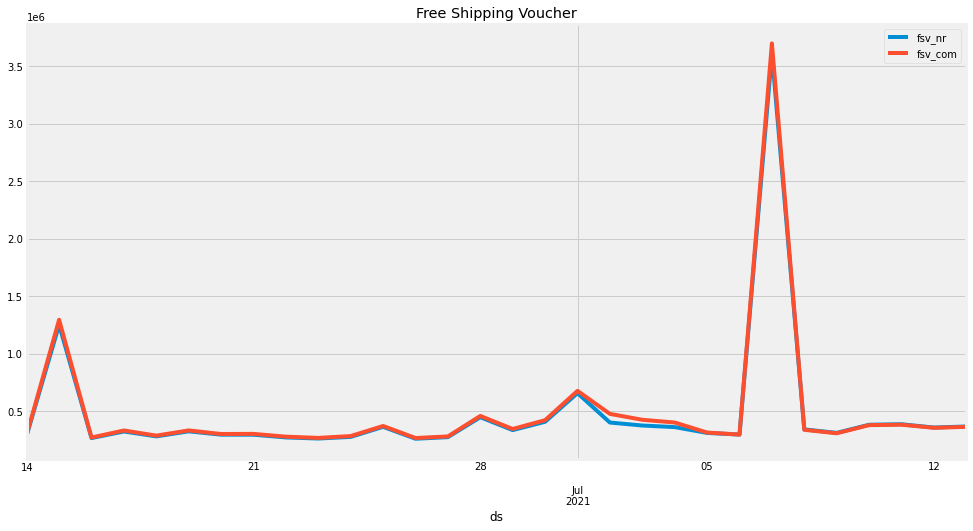

In [ ]:
# free shipping voucher
fsv_nr = cal['forecast']*cal['estimate_shipping_rebate_by_shopee_amt_usd']
fsv = pd.DataFrame(fsv_nr,columns={'fsv_nr'})
fsv_com = pd.DataFrame(cost_com['actual_shipping_rebate_by_shopee_amt_usd'])
fsv = fsv.join(fsv_com['actual_shipping_rebate_by_shopee_amt_usd'],how='left').rename(columns={'actual_shipping_rebate_by_shopee_amt_usd':'fsv_com'})
fsv.plot()
plt.title('Free Shipping Voucher')

Text(0.5, 1.0, 'Mall coin')

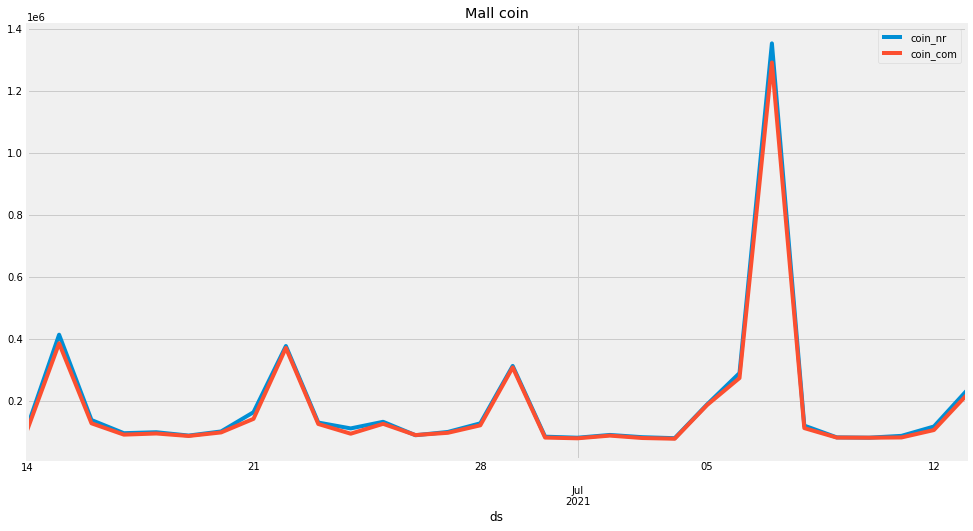

In [ ]:
# mall coin
coin_nr = cal['forecast']*cal['coin_rate']*cal['coin_earn_cash_amt_usd']
coin = pd.DataFrame(coin_nr,columns={'coin_nr'})
coin_com = pd.DataFrame(cost_com['coin_earn_cash_amt_usd'])
coin = coin.join(coin_com['coin_earn_cash_amt_usd'],how='left').rename(columns={'coin_earn_cash_amt_usd':'coin_com'})
coin.plot()
plt.title('Mall coin')

Text(0.5, 1.0, 'Discount Voucher')

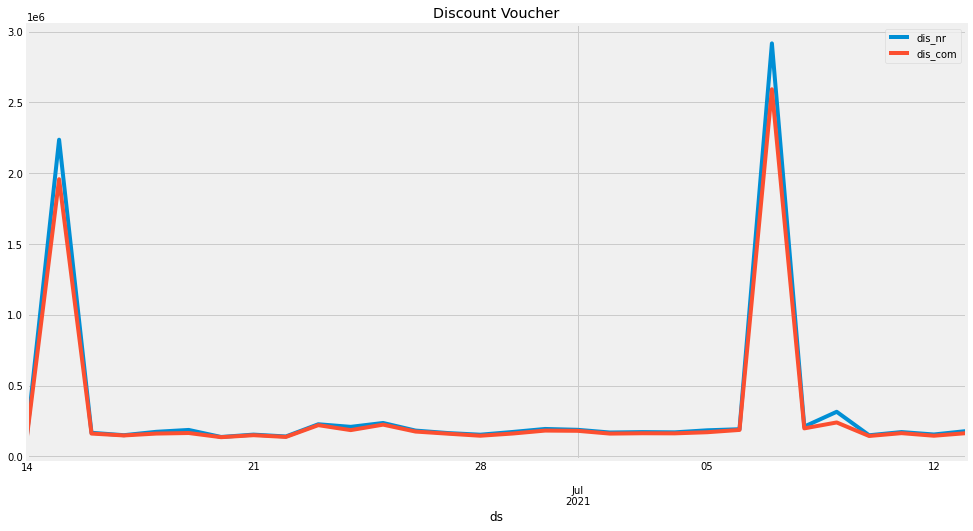

In [ ]:
# discount voucher
dis_nr = cal['forecast']*(cal['pv_rebate_by_shopee_amt_usd'] + cal['sv_rebate_by_shopee_amt_usd'])
dis = pd.DataFrame(dis_nr,columns={'dis_nr'})
dis_com = pd.DataFrame(cost_com['pv_rebate_by_shopee_amt_usd'] + cost_com['sv_rebate_by_shopee_amt_usd'])
dis = dis.join(dis_com,how='left').rename(columns={0:'dis_com'})
dis.plot()
plt.title('Discount Voucher')

Text(0.5, 1.0, 'Coin Voucher')

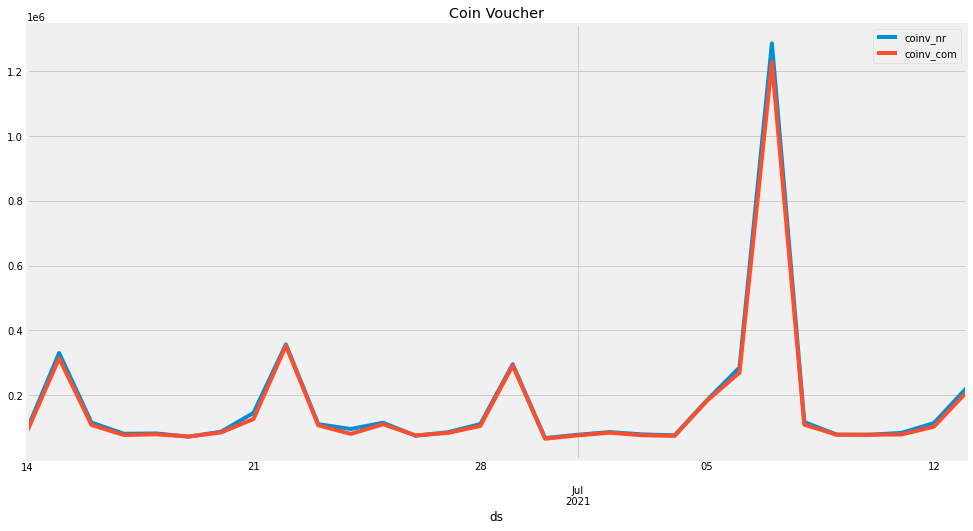

In [ ]:
# coin voucher
coinv_nr = cal['forecast']*(cal['pv_coin_earn_by_shopee_amt_usd'] + cal['sv_coin_earn_by_shopee_amt_usd'])*cal['coin_rate']
coinv = pd.DataFrame(coinv_nr,columns={'coinv_nr'})
coinv_com = pd.DataFrame(cost_com['pv_coin_earn_by_shopee_amt_usd'] + cost_com['sv_coin_earn_by_shopee_amt_usd'])
coinv = coinv.join(coinv_com,how='left').rename(columns={0:'coinv_com'})
coinv.plot()
plt.title('Coin Voucher')

Text(0.5, 1.0, 'Net Cost')

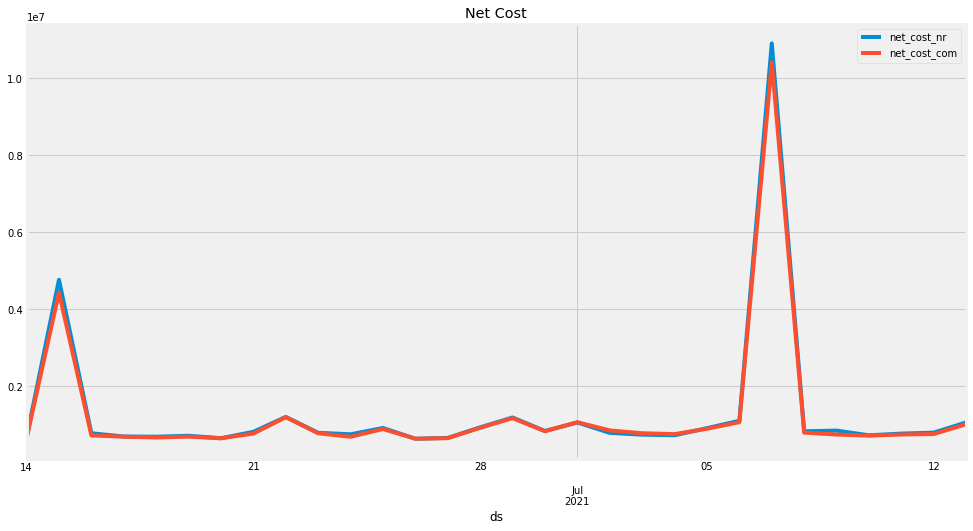

In [ ]:
# net cost
net_cost_nr = item_rebate['item_rebate_nr'] + fsv['fsv_nr'] + coin['coin_nr'] + dis['dis_nr'] + coinv['coinv_nr']
net_cost = pd.DataFrame(net_cost_nr,columns={'net_cost_nr'})
net_cost_com = item_rebate['item_rebate_com'] + fsv['fsv_com'] + coin['coin_com'] + dis['dis_com'] + coinv['coinv_com']
net_cost['net_cost_com'] = net_cost_com
net_cost.plot()
plt.title('Net Cost')

In [ ]:
# root mean squared error
mse = mean_squared_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# mean absolute error
mae = mean_absolute_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# mean squared error
mse = mean_squared_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# median absolute error
MDAE = np.median(abs(net_cost['net_cost_nr'] - net_cost['net_cost_com']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(net_cost['net_cost_nr'], net_cost['net_cost_com'])/ net_cost['net_cost_com']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,1.277777e+10
rmse,1.130388e+05
mae,5.310841e+04
mape,3.508445e+00
mdae,2.320918e+04
mdape,3.171605e+00


## cost with old net rate

Text(0.5, 1.0, 'Item Rebate')

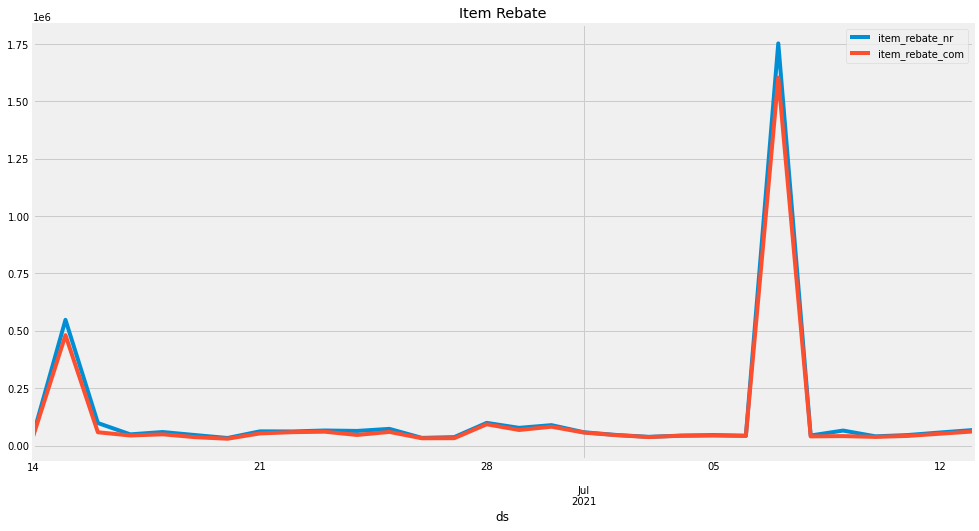

In [ ]:
# item_rebate
item_rebate_nr = cal['old_nr']*cal['item_rebate_by_shopee_amt_usd']
item_rebate = pd.DataFrame(item_rebate_nr,columns={'item_rebate_nr'})
item_rebate_com = pd.DataFrame(cost_com['item_rebate_by_shopee_amt_usd'])
item_rebate = item_rebate.join(item_rebate_com['item_rebate_by_shopee_amt_usd'],how='left').rename(columns={'item_rebate_by_shopee_amt_usd':'item_rebate_com'})
item_rebate.plot()
plt.title('Item Rebate')

Text(0.5, 1.0, 'Free Shipping Voucher')

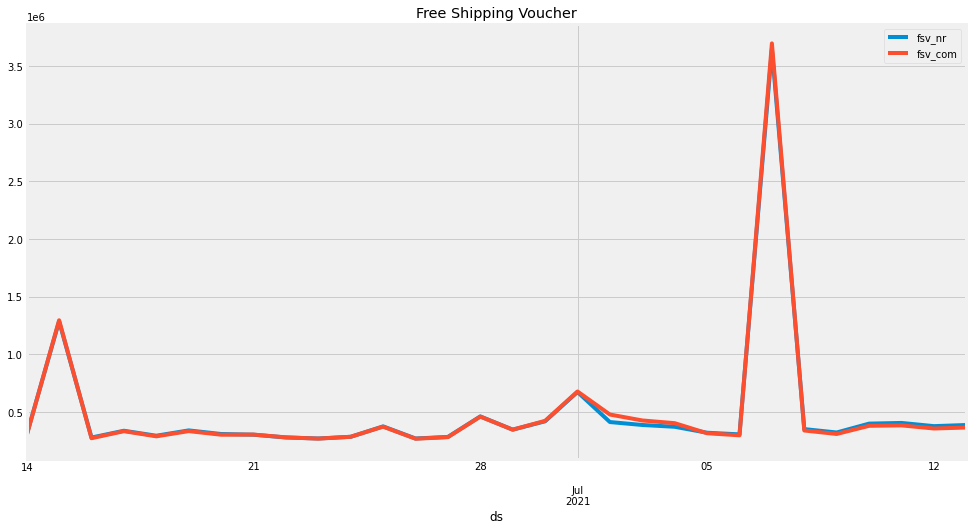

In [ ]:
# free shipping voucher
fsv_nr = cal['old_nr']*cal['estimate_shipping_rebate_by_shopee_amt_usd']
fsv = pd.DataFrame(fsv_nr,columns={'fsv_nr'})
fsv_com = pd.DataFrame(cost_com['actual_shipping_rebate_by_shopee_amt_usd'])
fsv = fsv.join(fsv_com['actual_shipping_rebate_by_shopee_amt_usd'],how='left').rename(columns={'actual_shipping_rebate_by_shopee_amt_usd':'fsv_com'})
fsv.plot()
plt.title('Free Shipping Voucher')

Text(0.5, 1.0, 'Mall coin')

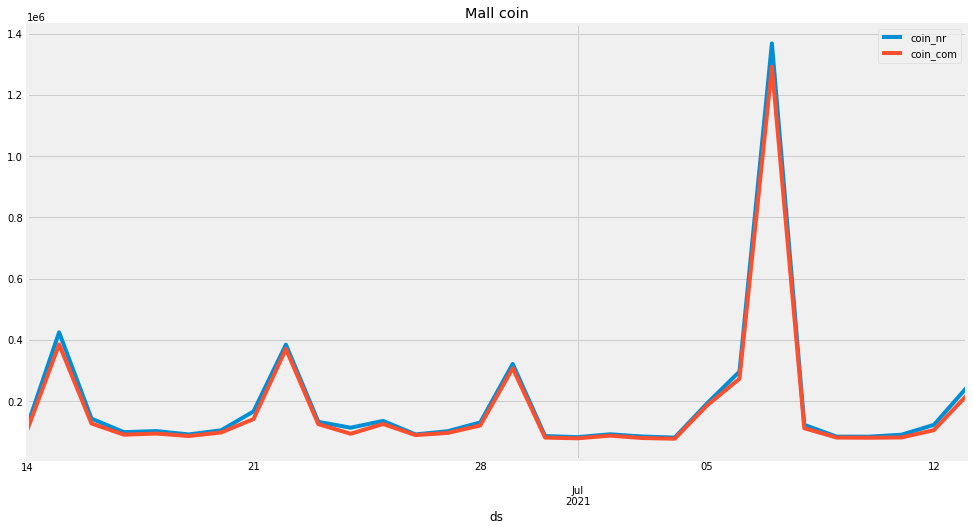

In [ ]:
# mall coin
coin_nr = cal['old_nr']*cal['coin_rate']*cal['coin_earn_cash_amt_usd']
coin = pd.DataFrame(coin_nr,columns={'coin_nr'})
coin_com = pd.DataFrame(cost_com['coin_earn_cash_amt_usd'])
coin = coin.join(coin_com['coin_earn_cash_amt_usd'],how='left').rename(columns={'coin_earn_cash_amt_usd':'coin_com'})
coin.plot()
plt.title('Mall coin')

Text(0.5, 1.0, 'Discount Voucher')

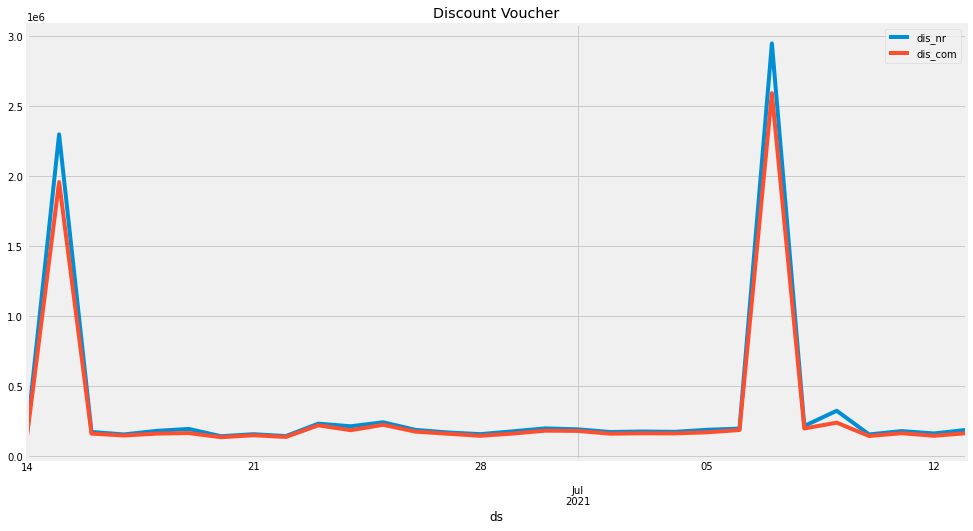

In [ ]:
# discount voucher
dis_nr = cal['old_nr']*(cal['pv_rebate_by_shopee_amt_usd'] + cal['sv_rebate_by_shopee_amt_usd'])
dis = pd.DataFrame(dis_nr,columns={'dis_nr'})
dis_com = pd.DataFrame(cost_com['pv_rebate_by_shopee_amt_usd'] + cost_com['sv_rebate_by_shopee_amt_usd'])
dis = dis.join(dis_com,how='left').rename(columns={0:'dis_com'})
dis.plot()
plt.title('Discount Voucher')

Text(0.5, 1.0, 'Coin Voucher')

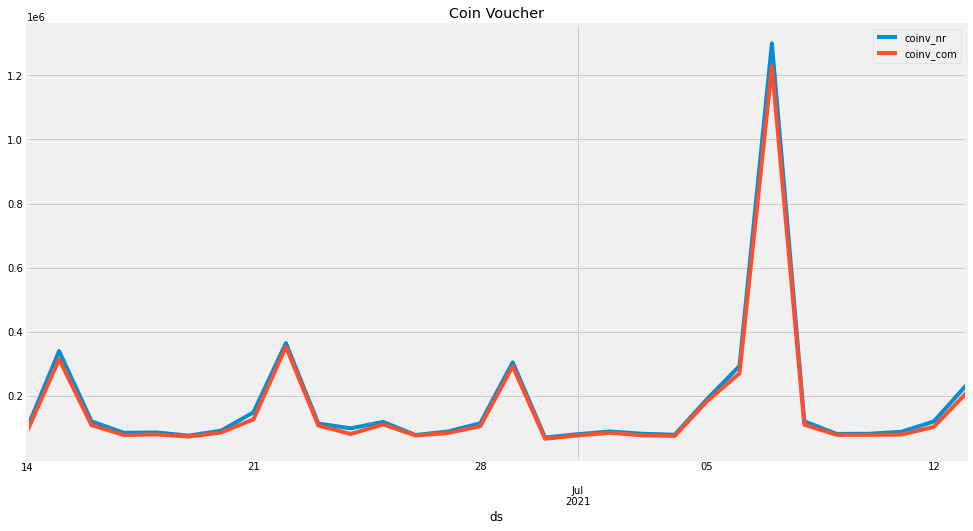

In [ ]:
# coin voucher
coinv_nr = cal['old_nr']*(cal['pv_coin_earn_by_shopee_amt_usd'] + cal['sv_coin_earn_by_shopee_amt_usd'])*cal['coin_rate']
coinv = pd.DataFrame(coinv_nr,columns={'coinv_nr'})
coinv_com = pd.DataFrame(cost_com['pv_coin_earn_by_shopee_amt_usd'] + cost_com['sv_coin_earn_by_shopee_amt_usd'])
coinv = coinv.join(coinv_com,how='left').rename(columns={0:'coinv_com'})
coinv.plot()
plt.title('Coin Voucher')

Text(0.5, 1.0, 'Net Cost')

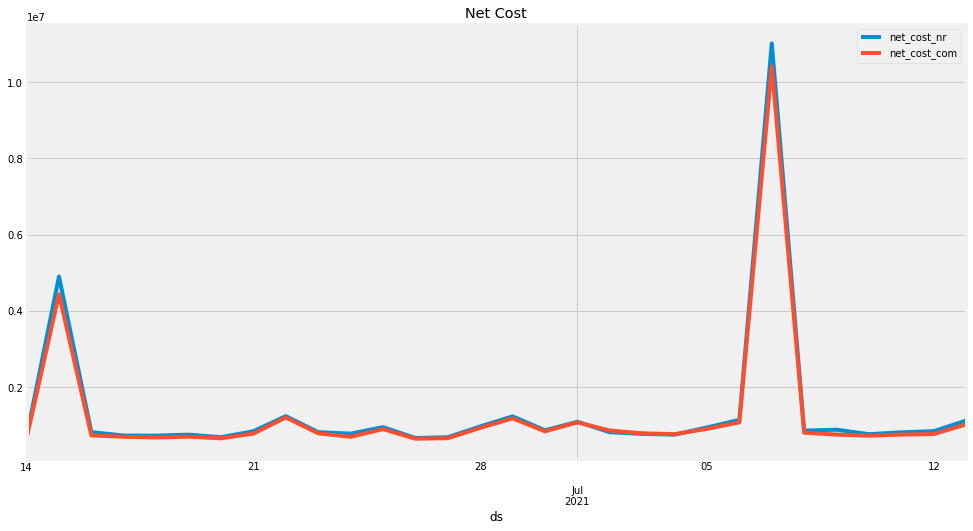

In [ ]:
# net cost
net_cost_nr = item_rebate['item_rebate_nr'] + fsv['fsv_nr'] + coin['coin_nr'] + dis['dis_nr'] + coinv['coinv_nr']
net_cost = pd.DataFrame(net_cost_nr,columns={'net_cost_nr'})
net_cost_com = item_rebate['item_rebate_com'] + fsv['fsv_com'] + coin['coin_com'] + dis['dis_com'] + coinv['coinv_com']
net_cost['net_cost_com'] = net_cost_com
net_cost.plot()
plt.title('Net Cost')

In [ ]:
# root mean squared error
mse = mean_squared_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# mean absolute error
mae = mean_absolute_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# mean squared error
mse = mean_squared_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# median absolute error
MDAE = np.median(abs(net_cost['net_cost_nr'] - net_cost['net_cost_com']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(net_cost['net_cost_nr'], net_cost['net_cost_com'])/ net_cost['net_cost_com']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,2.223606e+10
rmse,1.491176e+05
mae,8.124057e+04
mape,5.828130e+00
mdae,4.863181e+04
mdape,5.603925e+00


## cost with actual net rate

Text(0.5, 1.0, 'Item Rebate')

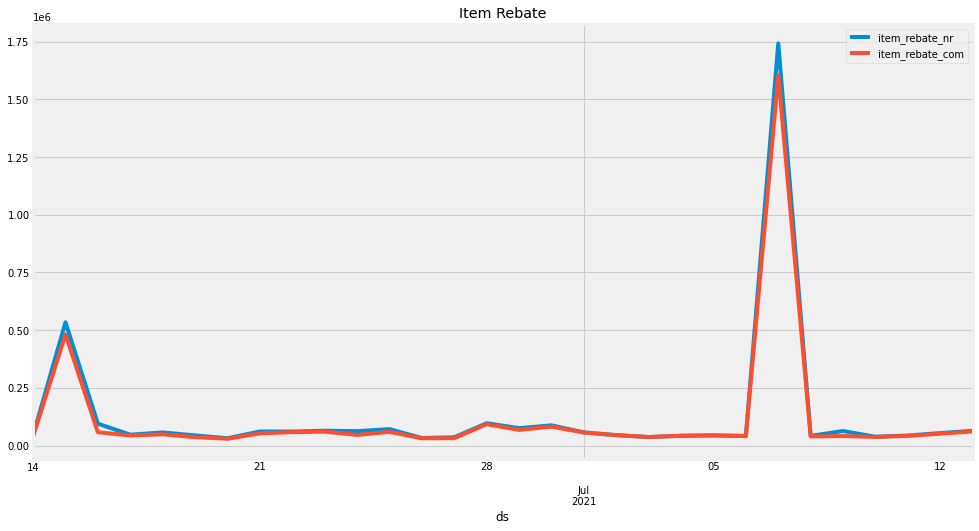

In [ ]:
# item_rebate
item_rebate_nr = cal['actual']*cal['item_rebate_by_shopee_amt_usd']
item_rebate = pd.DataFrame(item_rebate_nr,columns={'item_rebate_nr'})
item_rebate_com = pd.DataFrame(cost_com['item_rebate_by_shopee_amt_usd'])
item_rebate = item_rebate.join(item_rebate_com['item_rebate_by_shopee_amt_usd'],how='left').rename(columns={'item_rebate_by_shopee_amt_usd':'item_rebate_com'})
item_rebate.plot()
plt.title('Item Rebate')

Text(0.5, 1.0, 'Free Shipping Voucher')

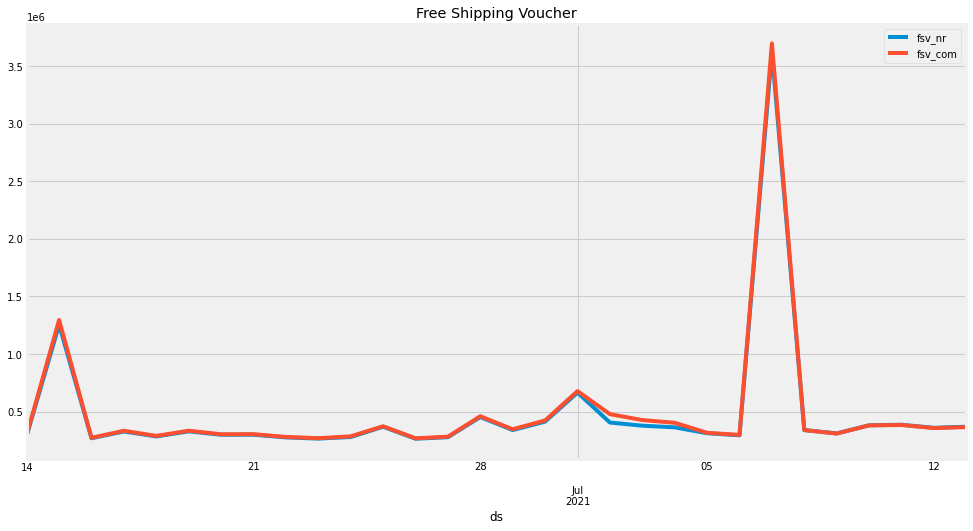

In [ ]:
# free shipping voucher
fsv_nr = cal['actual']*cal['estimate_shipping_rebate_by_shopee_amt_usd']
fsv = pd.DataFrame(fsv_nr,columns={'fsv_nr'})
fsv_com = pd.DataFrame(cost_com['actual_shipping_rebate_by_shopee_amt_usd'])
fsv = fsv.join(fsv_com['actual_shipping_rebate_by_shopee_amt_usd'],how='left').rename(columns={'actual_shipping_rebate_by_shopee_amt_usd':'fsv_com'})
fsv.plot()
plt.title('Free Shipping Voucher')

Text(0.5, 1.0, 'Mall coin')

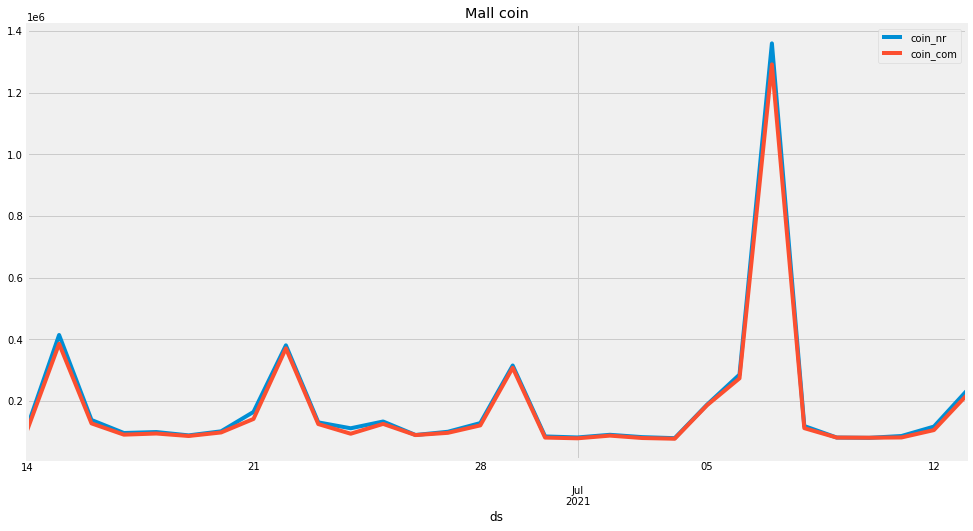

In [ ]:
# mall coin
coin_nr = cal['actual']*cal['coin_rate']*cal['coin_earn_cash_amt_usd']
coin = pd.DataFrame(coin_nr,columns={'coin_nr'})
coin_com = pd.DataFrame(cost_com['coin_earn_cash_amt_usd'])
coin = coin.join(coin_com['coin_earn_cash_amt_usd'],how='left').rename(columns={'coin_earn_cash_amt_usd':'coin_com'})
coin.plot()
plt.title('Mall coin')

Text(0.5, 1.0, 'Discount Voucher')

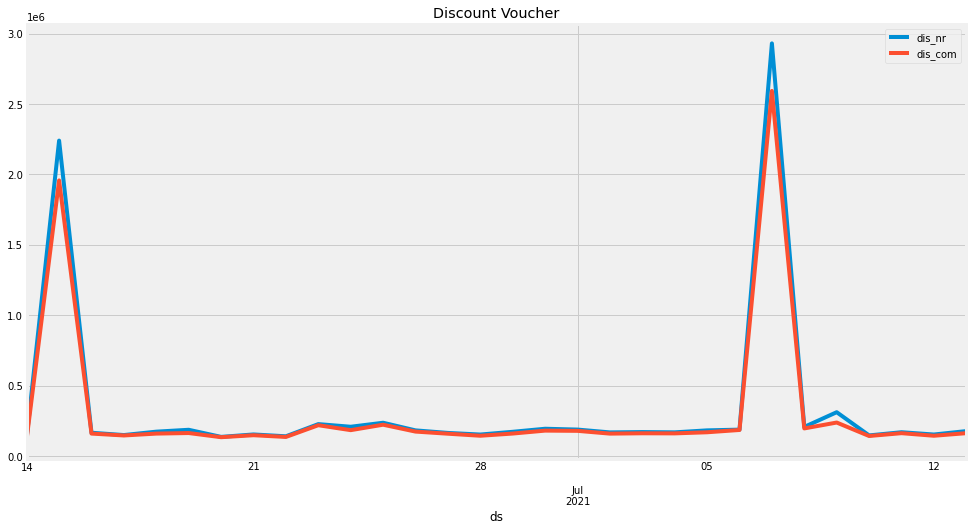

In [ ]:
# discount voucher
dis_nr = cal['actual']*(cal['pv_rebate_by_shopee_amt_usd'] + cal['sv_rebate_by_shopee_amt_usd'])
dis = pd.DataFrame(dis_nr,columns={'dis_nr'})
dis_com = pd.DataFrame(cost_com['pv_rebate_by_shopee_amt_usd'] + cost_com['sv_rebate_by_shopee_amt_usd'])
dis = dis.join(dis_com,how='left').rename(columns={0:'dis_com'})
dis.plot()
plt.title('Discount Voucher')

Text(0.5, 1.0, 'Coin Voucher')

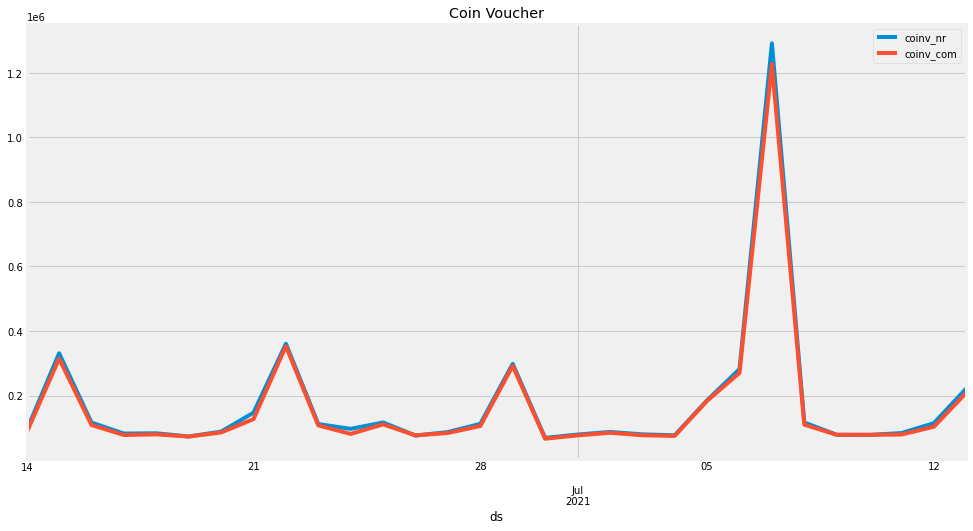

In [ ]:
# coin voucher
coinv_nr = cal['actual']*(cal['pv_coin_earn_by_shopee_amt_usd'] + cal['sv_coin_earn_by_shopee_amt_usd'])*cal['coin_rate']
coinv = pd.DataFrame(coinv_nr,columns={'coinv_nr'})
coinv_com = pd.DataFrame(cost_com['pv_coin_earn_by_shopee_amt_usd'] + cost_com['sv_coin_earn_by_shopee_amt_usd'])
coinv = coinv.join(coinv_com,how='left').rename(columns={0:'coinv_com'})
coinv.plot()
plt.title('Coin Voucher')

Text(0.5, 1.0, 'Net Cost')

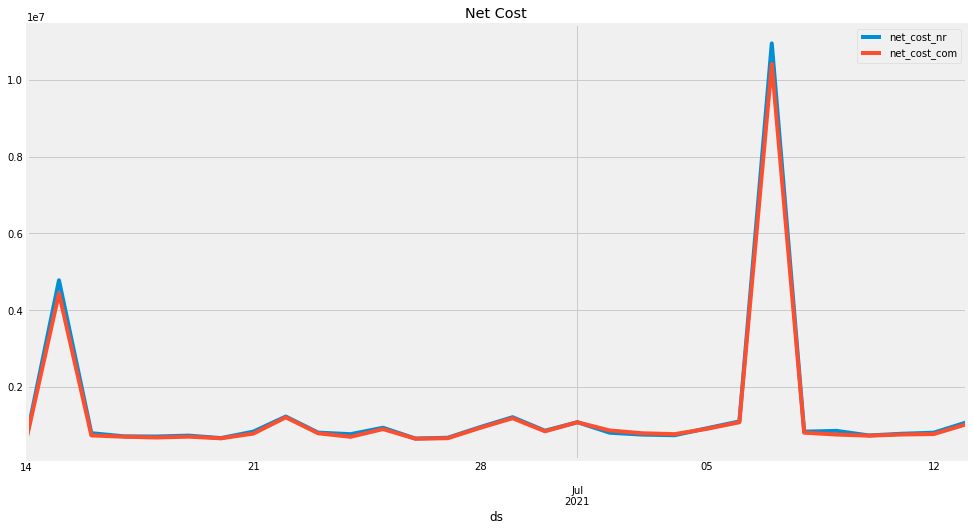

In [ ]:
# net cost
net_cost_nr = item_rebate['item_rebate_nr'] + fsv['fsv_nr'] + coin['coin_nr'] + dis['dis_nr'] + coinv['coinv_nr']
net_cost = pd.DataFrame(net_cost_nr,columns={'net_cost_nr'})
net_cost_com = item_rebate['item_rebate_com'] + fsv['fsv_com'] + coin['coin_com'] + dis['dis_com'] + coinv['coinv_com']
net_cost['net_cost_com'] = net_cost_com
net_cost.plot()
plt.title('Net Cost')

In [ ]:
# root mean squared error
mse = mean_squared_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])
rmse = sqrt(mse)

# mean absolute percent error
mape = MAPE(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# mean absolute error
mae = mean_absolute_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# mean squared error
mse = mean_squared_error(net_cost['net_cost_nr'], net_cost['net_cost_com'])

# median absolute error
MDAE = np.median(abs(net_cost['net_cost_nr'] - net_cost['net_cost_com']))

# median absolute percent error
MDAPE = np.median((np.abs(np.subtract(net_cost['net_cost_nr'], net_cost['net_cost_com'])/ net_cost['net_cost_com']))) * 100

index=['mse','rmse','mae','mape','mdae','mdape']
metrics = pd.DataFrame([mse,rmse,mae,mape,MDAE,MDAPE],columns={'metrics'})
metrics.index = index
metrics

,metrics
mse,1.467800e+10
rmse,1.211528e+05
mae,5.654011e+04
mape,3.713590e+00
mdae,2.614089e+04
mdape,3.572501e+00


# Predict 7 days net rate

In [ ]:
pp_train = multi_train.copy()
pp_train = pp_train.append(multi_val)
pp_train.tail()

,ds,y,dday,season
373,2021-07-09,0.846714,0,1
374,2021-07-10,0.845234,0,1
375,2021-07-11,0.850459,0,1
376,2021-07-12,0.854894,0,1
377,2021-07-13,0.855573,0,1


In [ ]:
tmr_model = Prophet(interval_width=0.95)

In [ ]:
tmr_model.add_regressor('dday', standardize=False)
tmr_model.add_regressor('season', standardize=False)

In [ ]:
tmr_model.fit(pp_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
tmr_future = tmr_model.make_future_dataframe(periods=7)
tmr_future.tail()

,ds
380,2021-07-16
381,2021-07-17
382,2021-07-18
383,2021-07-19
384,2021-07-20


In [ ]:
dday = []
for i in range(len(tmr_future)):
    st = str(tmr_future.ds[i])
    if st[5:7] == st[8:10]:
        day = 1
        dday.append(day)
        continue
    if st[8:10] == '15':
        day = 1
        dday.append(day)
        continue
    else:
        day = 0
        dday.append(day)

tmr_future['dday'] = dday
tmr_future.tail()

,ds,dday
380,2021-07-16,0
381,2021-07-17,0
382,2021-07-18,0
383,2021-07-19,0
384,2021-07-20,0


In [ ]:
season=[]
summer = [3,4,5,6]
rain = [7,8,9,10]
winter = [11,12,1,2]

for i in range(len(tmr_future)):
  st = str(tmr_future.ds[i])
  if int(st[5:7]) in summer:
    num_season = 0
    season.append(num_season)
    continue
  if int(st[5:7]) in rain:
    num_season = 1
    season.append(num_season)
    continue
  if int(st[5:7]) in winter:
    num_season = 2
    season.append(num_season)
    continue

tmr_future['season'] = season
tmr_future.tail()

,ds,dday,season
380,2021-07-16,0,1
381,2021-07-17,0,1
382,2021-07-18,0,1
383,2021-07-19,0,1
384,2021-07-20,0,1


In [ ]:
tmr_forecast = tmr_model.predict(tmr_future)
tmr_forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
380,2021-07-16,0.857485,0.842630,0.871673
381,2021-07-17,0.855445,0.842137,0.870371
382,2021-07-18,0.859223,0.845141,0.873316
383,2021-07-19,0.859415,0.845118,0.873231
384,2021-07-20,0.858196,0.843563,0.872637


In [ ]:
tmr_forecast[['ds','yhat','yhat_lower','yhat_upper']][383:]

,ds,yhat,yhat_lower,yhat_upper
383,2021-07-19,0.859415,0.845118,0.873231
384,2021-07-20,0.858196,0.843563,0.872637


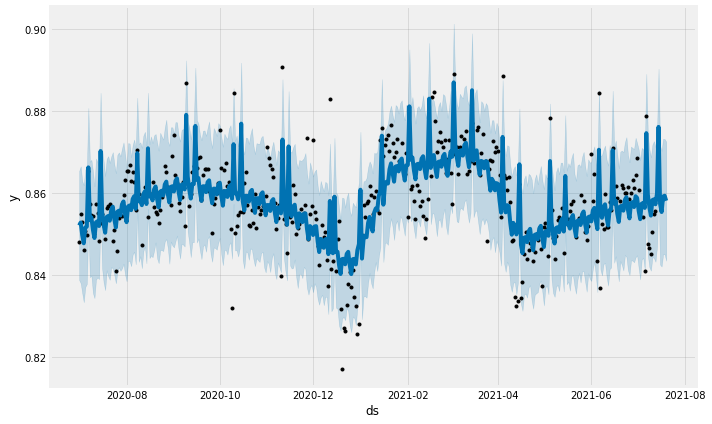

In [ ]:
tmr_fig = tmr_model.plot(tmr_forecast)

# Data Exploration

In [ ]:
df = pd.read_csv('/content/drive/My Drive/net_rate/Data/order_fe_status_20jul21.csv')
df = df[df.grass_date != '9999-01-01']
df.reset_index(inplace=True, drop=True)
df['grass_date']= pd.to_datetime(df['grass_date'])
df = df.set_index(['grass_date'])
df = df.sort_index()
df[df.index=='2021-07-19']

,order_fe_status,count
grass_date,,
2021-07-19,TO_RECEIVE,2
2021-07-19,COMPLETED,2089982
2021-07-19,TO_SHIP,2
2021-07-19,CANCELLED,372380


In [ ]:
gmv_com[-7:]

,gmv_usd
grass_date,
2021-07-13,1.761464e+07
2021-07-14,1.837069e+07
2021-07-15,2.127223e+07
2021-07-16,1.773212e+07
2021-07-17,1.819285e+07
2021-07-18,1.671614e+07
2021-07-19,1.650634e+07


In [ ]:
gmv_can[-7:]

,gmv_usd
grass_date,
2021-07-13,3.832506e+06
2021-07-14,4.230269e+06
2021-07-15,8.149545e+06
2021-07-16,5.696099e+06
2021-07-17,4.177975e+06
2021-07-18,3.740570e+06
2021-07-19,4.126154e+06


In [ ]:
gmv_com[-7:]-gmv_can[-7:]

,gmv_usd
grass_date,
2021-07-13,1.378213e+07
2021-07-14,1.414042e+07
2021-07-15,1.312269e+07
2021-07-16,1.203602e+07
2021-07-17,1.401487e+07
2021-07-18,1.297557e+07
2021-07-19,1.238019e+07


In [ ]:
cal[-7:]

,actual,forecast,item_rebate_by_shopee_amt_usd,estimate_shipping_rebate_by_shopee_amt_usd,actual_shipping_rebate_by_shopee_amt_usd,coin_earn_by_basic_cash_amt_usd,pv_rebate_by_shopee_amt_usd,sv_rebate_by_shopee_amt_usd,coin_rate,old_nr
ds,,,,,,,,,,
2021-07-13,0.875948,0.867837,187489.281421,642690.037210,586369.709395,2375.423603,368012.402072,18027.443874,0.975924,0.909957
2021-07-14,0.873480,0.903557,165891.973658,630125.986872,561293.209205,2973.598314,352150.712068,16557.472962,0.975924,0.907893
2021-07-15,0.869687,0.866724,256519.943784,829830.335951,706227.944349,4056.481321,611007.313305,18234.371230,0.975924,0.903592
2021-07-16,0.865798,0.847654,185906.376864,630430.841268,546594.787936,2637.604764,464306.033658,15037.059897,0.975924,0.902596
2021-07-17,0.858688,0.841521,181048.928008,672347.765665,582193.090142,1962.514735,479661.061921,15598.875718,0.975924,0.897443
2021-07-18,0.859658,0.872562,177124.490557,675612.395534,587843.130436,876.676687,484392.504285,12721.859339,0.975924,0.892993
2021-07-19,0.848771,0.867403,160340.876745,653892.408109,560678.593083,703.175572,439151.893758,10120.057304,0.975924,0.889285
